In [ ]:
import tensorflow.keras.applications.efficientnet as eff_net
from livelossplot.tf_keras import PlotLossesCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL

from pathlib import Path

In [ ]:
img = PIL.Image.open(r"base\airplane\captcha(1003).png")
img = eff_net.preprocess_input(img)

img = np.array(img)

plt.imshow(img)

In [ ]:
path_base = r"D:\KWork\Project 1"

file_source = Path(path_base) / "base"
train_file_destination = Path(path_base) / "data" / "train"
val_file_destination = Path(path_base) / "data" / "validation"

In [ ]:
def preprocess_input_model(_image):
    from PIL import Image
    
    crop_image = _image.crop((20, 30, 110, 90))
    crop_image = crop_image.resize((128, 128), Image.ANTIALIAS)
    
    return crop_image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_data = ImageDataGenerator(preprocessing_function=eff_net.preprocess_input,
                              rotation_range=5,
                              width_shift_range=0.1,
                              height_shift_range=0.02,
                              zoom_range=0.15,
                              fill_mode="nearest")

In [ ]:
BATCH_SIZE = 32
IMG_SHAPE = 128
IMAGE_SIZE = (128, 128, 3)

train_dir = train_file_destination
val_dir = val_file_destination

In [20]:
train_data_gen = gen_data.flow_from_directory(directory=train_dir,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              class_mode="sparse")

val_data_gen = gen_data.flow_from_directory(directory=val_dir,
                                            target_size=(IMG_SHAPE, IMG_SHAPE),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode="sparse")

Found 3809 images belonging to 8 classes.
Found 1629 images belonging to 8 classes.


In [21]:
def get_compiled_model():
    import tensorflow as tf
    import tensorflow.keras.applications.efficientnet as eff_net
    
    base_model = eff_net.EfficientNetB7(include_top=False,
                                        weights="imagenet",
                                        input_shape=IMAGE_SIZE)
    base_model.trainable = False

    model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(8, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.3e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [22]:
test_model = get_compiled_model()
test_model.load_weights(r"efficientnetb7/best_model.hdf5")

In [23]:
samples, labels = next(val_data_gen)
np.argmax(test_model.predict(samples), axis=-1)

array([1, 5, 0, 1, 6, 3, 6, 0, 0, 4, 1, 2, 4, 0, 5, 0, 3, 4, 4, 6, 7, 4,
       0, 5, 7, 1, 1, 3, 7, 6, 6, 1], dtype=int64)

In [10]:
test_model.evaluate(val_data_gen)

51/51 [==============================] - 36s 432ms/step - loss: 0.5302 - accuracy: 0.8269


[0.5302122831344604, 0.8268876671791077]

In [25]:
def show_results(images, labels, predictions=None):
    plt.figure(figsize=(12, 12))
    
    for i in range(0, 12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        if predictions is not None:
            title = plt.title(f"Real:{list(val_data_gen.class_indices.keys())[int(labels[i])]}|Pred:{list(val_data_gen.class_indices.keys())[predictions[i]]}")
            plt.setp(title, c="w")
            
            if predictions[i] != labels[i]:
                plt.setp(title, c="r")
            
    plt.show()

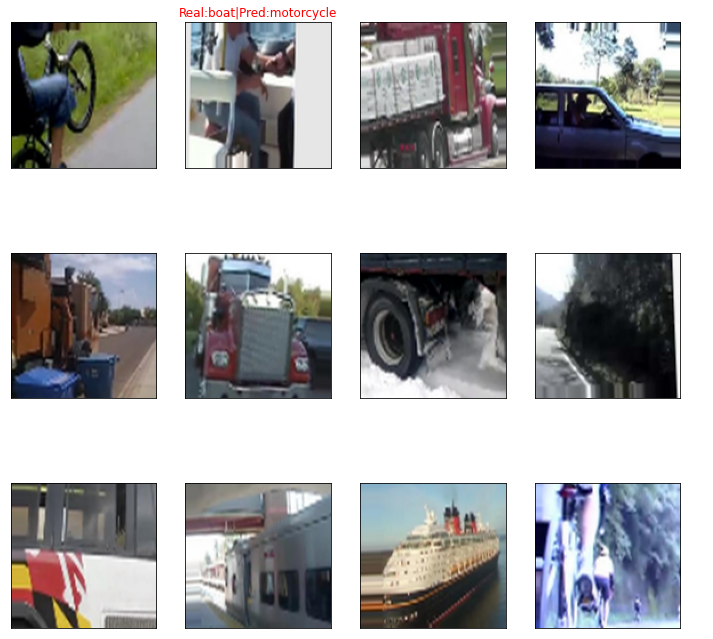

In [30]:
samples, labels = next(val_data_gen)
predictions = np.argmax(test_model.predict(samples), axis=-1)
samples = samples.astype(np.int)
show_results(samples, labels, predictions)